<a href="https://colab.research.google.com/github/Pengchengzhi/Face-Alignment-DRF/blob/main/Fit_Common_test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Random Forest

* Improve accuracy:

```
1. Move top1 towards top2 by 1/4

```

* Ablation study

```
1. Anneal range (1-3 or 1-100)
2. Leaf Node dimension
3. Number of Trees
```

In [ ]:
!nvidia-smi

Thu Jul 15 07:14:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    33W / 250W |    913MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# function ConnectButton(){
#   console.log("Connect pushed"); 
#   document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
# }
# setInterval(ConnectButton,60000);


# clearInterval(37042)

# watch -n 0.1 -d nvidia-smi

# 1. Initialize

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import os
path="/content/drive/My Drive/Face Alignment DRF"
os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['__pycache__',
 'utils',
 'datasets',
 'trained_models',
 'checkpoints',
 'Landmarks_Correlation.ipynb',
 'DataPreprocessing_Helen_300W.ipynb',
 'DataPreprocessing_AFW_300W.ipynb',
 'DataPreprocessing_LFPW_300W.ipynb',
 'DataPreprocessing_IBUG_300W.ipynb',
 'DataPreprocessing_Merge_300W.ipynb',
 'Untitled0.ipynb',
 'Final_Datasets',
 'Useless notebooks',
 'Heatmap_each_Cluster_Test_300W.ipynb',
 'DataPreprocessing_COFW.ipynb',
 'Train_on_Common',
 'Train_on_Common2',
 'Heatmap_each_Cluster_Train_300W.ipynb']

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import cv2
import json
import pandas as pd
from PIL import Image
import torchvision.models as models
import pdb
from torch.nn import Upsample
from torch.autograd import Variable
import torch.optim as optim
import time

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
from utils.hourglass_common import *
from utils.dataloader300w import *

In [4]:
# Landmarks Group
group_landmarks = torch.tensor([8, 3, 3, 3, 3, 6, 6, 6, 6, 6,
                 4, 4, 4, 4, 5, 5, 5, 8, 8, 8, 
                 8, 9, 1, 1, 1, 1, 1, 9, 9, 0, 
                 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 
                 9, 9, 7, 7, 7, 7, 7, 7, 2, 2, 
                 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
                 2, 2, 2, 2, 2, 2, 2, 2]).to(device)

Num_Clusters = 10
variance_gaussian = 3

cluster_len = torch.tensor([7,5,20,4,4,3,5,6,5,9]).to(device)
dim_tree = torch.tensor([5,5,6,5,5,5,5,5,5,5]).to(device)
num_tree = torch.tensor([3,3,4,2,2,2,3,3,3,4]).to(device)

num_fc = torch.sum(num_tree*(2**(dim_tree-1)-1)).item()
num_leaf_nodes = num_tree*2**(dim_tree-1)
total_num_leaf_nodes = torch.sum(num_leaf_nodes).item()

# 2. Data Loader - Train

In [5]:
w300_commonset = W300_set(dataset_type="common", var=3)
ccommon_dataloder = DataLoader(w300_commonset, batch_size=5, pin_memory=True, shuffle=True, drop_last=True)
rcommon_dataloder = DataLoader(w300_commonset, batch_size=50, pin_memory=True, shuffle=True, drop_last=True)

Loading [1/554] pictures......
Loading [100/554] pictures......
Loading [200/554] pictures......
Loading [300/554] pictures......
Loading [400/554] pictures......
Loading [500/554] pictures......


# 3. Pretrain

In [ ]:
w300_trainset = W300_set(dataset_type="train", var=3)
train_dataloder = DataLoader(w300_trainset, batch_size=5, pin_memory=True, shuffle=True, drop_last=True)

Loading [1/3148] pictures......
Loading [200/3148] pictures......
Loading [400/3148] pictures......
Loading [600/3148] pictures......
Loading [800/3148] pictures......
Loading [1000/3148] pictures......
Loading [1200/3148] pictures......
Loading [1400/3148] pictures......
Loading [1600/3148] pictures......
Loading [1800/3148] pictures......
Loading [2000/3148] pictures......
Loading [2200/3148] pictures......
Loading [2400/3148] pictures......
Loading [2600/3148] pictures......
Loading [2800/3148] pictures......
Loading [3000/3148] pictures......


In [ ]:
HGNet = HGNet().to(device)
Linear0 = Lin(numOut=cluster_len[0]).to(device)
Linear1 = Lin(numOut=cluster_len[1]).to(device)
Linear2 = Lin(numOut=cluster_len[2]).to(device)
Linear3 = Lin(numOut=cluster_len[3]).to(device)
Linear4 = Lin(numOut=cluster_len[4]).to(device)
Linear5 = Lin(numOut=cluster_len[5]).to(device)
Linear6 = Lin(numOut=cluster_len[6]).to(device)
Linear7 = Lin(numOut=cluster_len[7]).to(device)
Linear8 = Lin(numOut=cluster_len[8]).to(device)
Linear9 = Lin(numOut=cluster_len[9]).to(device)

In [ ]:
nIters = 50
critical = torch.nn.MSELoss()
optimizer = optim.SGD(HGNet.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer0 = optim.SGD(Linear0.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer1 = optim.SGD(Linear1.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer2 = optim.SGD(Linear2.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer3 = optim.SGD(Linear3.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer4 = optim.SGD(Linear4.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer5 = optim.SGD(Linear5.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer6 = optim.SGD(Linear6.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer7 = optim.SGD(Linear7.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer8 = optim.SGD(Linear8.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer9 = optim.SGD(Linear9.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [ ]:
loss_hist = torch.zeros(nIters)
loss_epoch = torch.zeros(629)

pretrain_start = time.time()
for iter in range(nIters):
  for i, (x,_,y) in enumerate(train_dataloder):
    x = Variable(x,requires_grad=True).float().to(device)
    y = Variable(y).float().to(device)
    B = x.shape[0]
    y_pred = torch.zeros(B,68,256,256).to(device)

    hg_out = HGNet.forward(x) #(B,128,256,256)
    y_pred[:,group_landmarks==0,:,:] = Linear0.forward(hg_out)
    y_pred[:,group_landmarks==1,:,:] = Linear1.forward(hg_out)
    y_pred[:,group_landmarks==2,:,:] = Linear2.forward(hg_out)
    y_pred[:,group_landmarks==3,:,:] = Linear3.forward(hg_out)
    y_pred[:,group_landmarks==4,:,:] = Linear4.forward(hg_out)
    y_pred[:,group_landmarks==5,:,:] = Linear5.forward(hg_out)
    y_pred[:,group_landmarks==6,:,:] = Linear6.forward(hg_out)
    y_pred[:,group_landmarks==7,:,:] = Linear7.forward(hg_out)
    y_pred[:,group_landmarks==8,:,:] = Linear8.forward(hg_out)
    y_pred[:,group_landmarks==9,:,:] = Linear9.forward(hg_out)

    loss = critical(y_pred, y)
    loss_epoch[i] = loss.item()

    optimizer.zero_grad()
    optimizer0.zero_grad()
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    optimizer3.zero_grad()
    optimizer4.zero_grad()
    optimizer5.zero_grad()
    optimizer6.zero_grad()
    optimizer7.zero_grad()
    optimizer8.zero_grad()
    optimizer9.zero_grad()
    loss.backward()
    optimizer.step()
    optimizer0.step()
    optimizer1.step()
    optimizer2.step()
    optimizer3.step()
    optimizer4.step()
    optimizer5.step()
    optimizer6.step()
    optimizer7.step()
    optimizer8.step()
    optimizer9.step()

    if i == 628:
      loss_avg = torch.sum(loss_epoch)/629
      loss_hist[iter] = loss_avg
      pretrain_break = time.time()
      print('Iter [%d/%d] loss %.6f  -----> %.2f hrs' %(iter+1, nIters, loss_avg, (pretrain_break-pretrain_start)/3600))
      torch.save(HGNet.state_dict(), "Train_on_Common/pretrain/Stacked_HGNet_Middle.pt")
      torch.save(Linear0.state_dict(), "Train_on_Common/pretrain/Linear0_Middle.pt")
      torch.save(Linear1.state_dict(), "Train_on_Common/pretrain/Linear1_Middle.pt")
      torch.save(Linear2.state_dict(), "Train_on_Common/pretrain/Linear2_Middle.pt")
      torch.save(Linear3.state_dict(), "Train_on_Common/pretrain/Linear3_Middle.pt")
      torch.save(Linear4.state_dict(), "Train_on_Common/pretrain/Linear4_Middle.pt")
      torch.save(Linear5.state_dict(), "Train_on_Common/pretrain/Linear5_Middle.pt")
      torch.save(Linear6.state_dict(), "Train_on_Common/pretrain/Linear6_Middle.pt")
      torch.save(Linear7.state_dict(), "Train_on_Common/pretrain/Linear7_Middle.pt")
      torch.save(Linear8.state_dict(), "Train_on_Common/pretrain/Linear8_Middle.pt")
      torch.save(Linear9.state_dict(), "Train_on_Common/pretrain/Linear9_Middle.pt")
        
torch.save(HGNet.state_dict(), "Train_on_Common/pretrain/Stacked_HGNet.pt")
torch.save(Linear0.state_dict(), "Train_on_Common/pretrain/Linear0.pt")
torch.save(Linear1.state_dict(), "Train_on_Common/pretrain/Linear1.pt")
torch.save(Linear2.state_dict(), "Train_on_Common/pretrain/Linear2.pt")
torch.save(Linear3.state_dict(), "Train_on_Common/pretrain/Linear3.pt")
torch.save(Linear4.state_dict(), "Train_on_Common/pretrain/Linear4.pt")
torch.save(Linear5.state_dict(), "Train_on_Common/pretrain/Linear5.pt")
torch.save(Linear6.state_dict(), "Train_on_Common/pretrain/Linear6.pt")
torch.save(Linear7.state_dict(), "Train_on_Common/pretrain/Linear7.pt")
torch.save(Linear8.state_dict(), "Train_on_Common/pretrain/Linear8.pt")
torch.save(Linear9.state_dict(), "Train_on_Common/pretrain/Linear9.pt")


plt.plot(torch.arange(nIters),loss_hist.detach().numpy())
plt.title("Training Loss")

Iter [1/200] loss 0.214095  -----> 0.11 hrs
Iter [2/200] loss 0.095690  -----> 0.23 hrs
Iter [3/200] loss 0.056668  -----> 0.34 hrs
Iter [4/200] loss 0.034982  -----> 0.45 hrs
Iter [5/200] loss 0.022611  -----> 0.57 hrs
Iter [6/200] loss 0.014749  -----> 0.68 hrs
Iter [7/200] loss 0.009394  -----> 0.79 hrs
Iter [8/200] loss 0.006090  -----> 0.91 hrs
Iter [9/200] loss 0.004140  -----> 1.02 hrs
Iter [10/200] loss 0.002867  -----> 1.14 hrs
Iter [11/200] loss 0.002038  -----> 1.25 hrs
Iter [12/200] loss 0.001552  -----> 1.36 hrs
Iter [13/200] loss 0.001220  -----> 1.48 hrs
Iter [14/200] loss 0.001005  -----> 1.59 hrs
Iter [15/200] loss 0.000849  -----> 1.70 hrs
Iter [16/200] loss 0.000723  -----> 1.82 hrs
Iter [17/200] loss 0.000614  -----> 1.93 hrs
Iter [18/200] loss 0.000545  -----> 2.04 hrs
Iter [19/200] loss 0.000474  -----> 2.16 hrs
Iter [20/200] loss 0.000446  -----> 2.27 hrs
Iter [21/200] loss 0.000379  -----> 2.38 hrs
Iter [22/200] loss 0.000348  -----> 2.50 hrs
Iter [23/200] loss 

KeyboardInterrupt: ignored

# 4. Tune Training

## 4.1 Functions

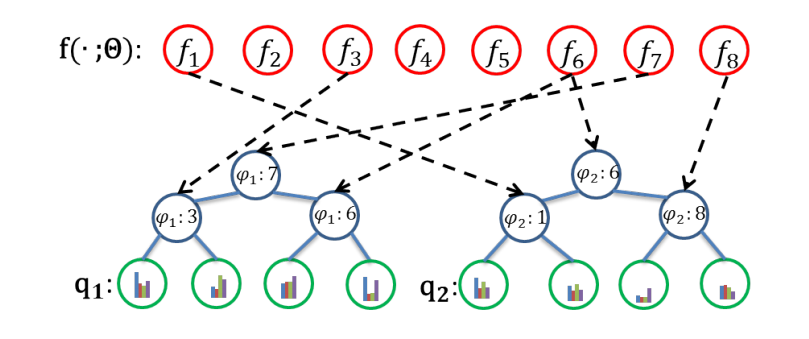

In [6]:
def leaf_direction(N):
  point = torch.zeros(2**N,N).to(device)

  def get01(number, len):
    result = torch.zeros(len).to(device)
    ind = len
    while ind >0:
      if 2**(ind-1)<=number:
        result[len-ind] = 1
        number -= 2**(ind-1)
      ind -= 1
    return result
  
  for i in range(2**N):
    point[i,:] = get01(i,N)

  return point.int()

In [7]:
def split_tree(up,here,which=0,mode='Second'):
  if mode=='initial':
    if which == 0:
      return here
    else: return (1-here)
  else:
    if which == 0:
      return up*here
    else: return up*(1-here)

In [8]:
def split_base(N):
  # returns index that split based on which cnn_fc col
  res = torch.zeros(2**N*N).to(device)
  lenth = 2**(N-1)
  num = 1
  left = 0
  repeat = 1
  max_repeat = 1
  while lenth>0 and repeat<2**N:
    res[left:left+lenth*2] = num
    left += lenth*2
    num += 1
    repeat -= 1
    if repeat == 0:
      lenth = int(lenth/2)
      repeat = max_repeat*2
      max_repeat = repeat
  return ((res.reshape(N,2**N)-1).T).int()

In [9]:
def phi(cnn_fc,mode='train'):
  N = cnn_fc.shape[0]
  out = torch.zeros(N,total_num_leaf_nodes).to(device)
  sigm = torch.zeros(cnn_fc.shape).to(device)

  if mode == 'test':
    sigm[cnn_fc>0] = 1
  else:
    sigm = torch.sigmoid(cnn_fc)

  for cluster_ind in range(Num_Clusters):
    the_dim_tree = dim_tree[cluster_ind].item()
    the_num_tree = num_tree[cluster_ind].item()
    out_y = torch.sum(num_leaf_nodes[0:cluster_ind]).item()

    direction = leaf_direction(the_dim_tree-1)
    tree_ind = split_base(the_dim_tree-1)
    X, Y = tree_ind.shape

    for ind_tree in range(the_num_tree):
      for x in range(X):
        for y in range(Y):
          here = sigm[:,ind_tree*(X-1)+tree_ind[x,y]]
          if y == 0:
            up = split_tree(torch.rand(3).to(device),here,which=direction[x,y],mode='initial')
          else:
            up = split_tree(up,here,which=direction[x,y])
          #print('y',y,'up',up)

        out[:,out_y+ind_tree*X+x] = up
    
  return out

In [10]:
def find_coord(prob_map, P):
  # prob_map(200,68*256*256)
  # P: number of points
  N = prob_map.shape[0]

  coord = torch.zeros(N,P*2).to(device)
  heatmap = prob_map.reshape(N,P,256,256).float()
  for n in range(N):
    for p in range(P):
      c1, c2 = torch.where(heatmap[n,p,:,:]==torch.max(heatmap[n,p,:,:]))
      coord[n,2*p], coord[n,2*p+1] = c1[0], c2[0]

  return coord

In [11]:
def get_mask(cnn_heatmaps,threshold=0.3):
  mask = torch.zeros(cnn_heatmaps.shape).to(device)
  B, P = cnn_heatmaps.shape[0:2]
  for b in range(B):
    for p in range(P):
      hm = cnn_heatmaps[b,p,:,:]
      mask[b,p,:,:][hm>torch.max(hm)*threshold]=1
  return mask

In [12]:
def update_iter(q, p, l):
  # q: leaf node
  # p: cnn probability
  # l: label

  gamma = torch.unsqueeze(p,2)*torch.unsqueeze(q,0) # (Ntrain,Nleaf,Nlabel)
  gamma = gamma/(torch.sum(gamma,axis=1,keepdims=True)+1e-8)
  score = torch.zeros(gamma.shape).to(q.device)
  for ll in range(q.shape[0]):
    score[:,ll,:] = l*gamma[:,ll,:]
  score = torch.sum(score,axis=0)+1e-8 # (3,2)

  return score/torch.sum(score,axis=1,keepdims=True)

In [13]:
# def loss_ce(B, q, p, l):
#   pred = torch.matmul(p,q.reshape(num_leaf_nodes,-1)).reshape(B*12,-1)
#   pred = pred/torch.sum(pred,axis=1,keepdims=True)
#   l = l.reshape(B*12,-1)
#   l = l/torch.sum(l,axis=1,keepdims=True)

#   return -criterion_KL(l,pred)

# def loss_l1(q, p, l):
#   return torch.sum(torch.abs(torch.matmul(p,q)-l))/l.shape[0]

def loss_alogb(B, q, p, l):
  np = q.shape[1]
  pred = torch.matmul(p,q.reshape(q.shape[0],-1)).reshape(B*np,-1)
  pred = pred/torch.sum(pred,axis=1,keepdims=True)
  l = l.reshape(B*np,-1)
  l = l/torch.sum(l,axis=1,keepdims=True)

  return -torch.sum(l*torch.log(pred))/B

In [14]:
# def mask_and_norm(target, mask):
#   # target (B,12,256,256)
#   # mask (B,12,256,256)
#   B,P = target.shape[0:2]

#   res = (target*mask).reshape(B,P,-1)
#   res = res/torch.sum(res,axis=2,keepdims=True)
#   return res.reshape(B,-1)

In [15]:
def get_heatmap_full(cnn_prob, leaf_q, mode='train'):
  # cnn_prob (B,total_num_leaf_nodes)
  # leaf_q, dict, each (nleaf, ncluster, 256, 256)
  B = cnn_prob.shape[0]
  heatmap = torch.zeros(B,68,256,256).to(device)

  for cluster_ind in range(Num_Clusters):
    nleaf_start = torch.sum(num_leaf_nodes[0:cluster_ind]).item()
    nleaf_end = torch.sum(num_leaf_nodes[0:cluster_ind+1]).item()
    pts_start = torch.sum(cluster_len[0:cluster_ind]).item()
    pts_end = torch.sum(cluster_len[0:cluster_ind+1]).item()

    this_prob = cnn_prob[:,nleaf_start:nleaf_end]
    this_leaf_q = leaf_q[cluster_ind]
    q1,q2 = this_leaf_q.shape[0:2]
    this_leaf_q = this_leaf_q.reshape(q1,-1)
    heatmap[:,pts_start:pts_end,:,:] = torch.matmul(this_prob,this_leaf_q).reshape(B,q2,256,256)
  
  # normalize heatmap
  heatmap = heatmap.reshape(B*68,-1)
  if mode == 'train':
    heatmap = heatmap/torch.sum(heatmap,axis=1,keepdims=True)
  else:
    for i in range(B*68):
      heatmap[i,:] = heatmap[i,:]/torch.sum(heatmap[i,:])

  return heatmap #(B*68,256*256)

## 4.2 Network

In [16]:
Tune_HGNet = HGNet().to(device)
Tune_HGNet.load_state_dict(torch.load("Train_on_Common/pretrain/Stacked_HGNet.pt"))

<All keys matched successfully>

In [17]:
Linear0_tune = Lin(tune=True,numOut=cluster_len[0]).to(device)
Linear0_tune.load_state_dict(torch.load("Train_on_Common/pretrain/Linear0.pt"))
Linear0_tune.tune = nn.Sequential(nn.Linear(cluster_len[0]*16*16,16*16),
                  # nn.Linear(16*16,16*16),
                  nn.Linear(16*16,num_leaf_nodes[0])).to(device)

Linear1_tune = Lin(tune=True,numOut=cluster_len[1]).to(device)
Linear1_tune.load_state_dict(torch.load("Train_on_Common/pretrain/Linear1.pt"))
Linear1_tune.tune = nn.Sequential(nn.Linear(cluster_len[1]*16*16,16*16),
                  # nn.Linear(16*16,16*16),
                  nn.Linear(16*16,num_leaf_nodes[1])).to(device)

Linear2_tune = Lin(tune=True,numOut=cluster_len[2]).to(device)
Linear2_tune.load_state_dict(torch.load("Train_on_Common/pretrain/Linear2.pt"))
Linear2_tune.tune = nn.Sequential(nn.Linear(cluster_len[2]*16*16,16*16),
                  # nn.Linear(16*16,16*16),
                  nn.Linear(16*16,num_leaf_nodes[2])).to(device)

Linear3_tune = Lin(tune=True,numOut=cluster_len[3]).to(device)
Linear3_tune.load_state_dict(torch.load("Train_on_Common/pretrain/Linear3.pt"))
Linear3_tune.tune = nn.Sequential(nn.Linear(cluster_len[3]*16*16,16*16),
                  # nn.Linear(16*16,16*16),
                  nn.Linear(16*16,num_leaf_nodes[3])).to(device)

Linear4_tune = Lin(tune=True,numOut=cluster_len[4]).to(device)
Linear4_tune.load_state_dict(torch.load("Train_on_Common/pretrain/Linear4.pt"))
Linear4_tune.tune = nn.Sequential(nn.Linear(cluster_len[4]*16*16,16*16),
                  # nn.Linear(16*16,16*16),
                  nn.Linear(16*16,num_leaf_nodes[4])).to(device)

Linear5_tune = Lin(tune=True,numOut=cluster_len[5]).to(device)
Linear5_tune.load_state_dict(torch.load("Train_on_Common/pretrain/Linear5.pt"))
Linear5_tune.tune = nn.Sequential(nn.Linear(cluster_len[5]*16*16,16*16),
                  # nn.Linear(16*16,16*16),
                  nn.Linear(16*16,num_leaf_nodes[5])).to(device)

Linear6_tune = Lin(tune=True,numOut=cluster_len[6]).to(device)
Linear6_tune.load_state_dict(torch.load("Train_on_Common/pretrain/Linear6.pt"))
Linear6_tune.tune = nn.Sequential(nn.Linear(cluster_len[6]*16*16,16*16),
                  # nn.Linear(16*16,16*16),
                  nn.Linear(16*16,num_leaf_nodes[6])).to(device)

Linear7_tune = Lin(tune=True,numOut=cluster_len[7]).to(device)
Linear7_tune.load_state_dict(torch.load("Train_on_Common/pretrain/Linear7.pt"))
Linear7_tune.tune = nn.Sequential(nn.Linear(cluster_len[7]*16*16,16*16),
                  # nn.Linear(16*16,16*16),
                  nn.Linear(16*16,num_leaf_nodes[7])).to(device)

Linear8_tune = Lin(tune=True,numOut=cluster_len[8]).to(device)
Linear8_tune.load_state_dict(torch.load("Train_on_Common/pretrain/Linear8.pt"))
Linear8_tune.tune = nn.Sequential(nn.Linear(cluster_len[8]*16*16,16*16),
                  # nn.Linear(16*16,16*16),
                  nn.Linear(16*16,num_leaf_nodes[8])).to(device)

Linear9_tune = Lin(tune=True,numOut=cluster_len[9]).to(device)
Linear9_tune.load_state_dict(torch.load("Train_on_Common/pretrain/Linear9.pt"))
Linear9_tune.tune = nn.Sequential(nn.Linear(cluster_len[9]*16*16,16*16),
                  # nn.Linear(16*16,16*16),
                  nn.Linear(16*16,num_leaf_nodes[9])).to(device)




# Linear0_tune.load_state_dict(torch.load("Train_on_Common/Linear0_Round1.pt"))
# Linear1_tune.load_state_dict(torch.load("Train_on_Common/Linear1_Round1.pt"))
# Linear2_tune.load_state_dict(torch.load("Train_on_Common/Linear2_Round1.pt"))
# Linear3_tune.load_state_dict(torch.load("Train_on_Common/Linear3_Round1.pt"))
# Linear4_tune.load_state_dict(torch.load("Train_on_Common/Linear4_Round1.pt"))
# Linear5_tune.load_state_dict(torch.load("Train_on_Common/Linear5_Round1.pt"))
# Linear6_tune.load_state_dict(torch.load("Train_on_Common/Linear6_Round1.pt"))
# Linear7_tune.load_state_dict(torch.load("Train_on_Common/Linear7_Round1.pt"))
# Linear8_tune.load_state_dict(torch.load("Train_on_Common/Linear8_Round1.pt"))
# Linear9_tune.load_state_dict(torch.load("Train_on_Common/Linear9_Round1.pt"))

In [18]:
leaf_q = torch.load("Train_on_Common/pretrain/leaf_q_Round1.pt")

## 4.3 Training

In [19]:
#######################
# Initialization
Total_train = 10

# CNN initilization
nIters = 200

optimizer  = optim.SGD(Tune_HGNet.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer0 = optim.SGD(Linear0_tune.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer1 = optim.SGD(Linear1_tune.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer2 = optim.SGD(Linear2_tune.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer3 = optim.SGD(Linear3_tune.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer4 = optim.SGD(Linear4_tune.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer5 = optim.SGD(Linear5_tune.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer6 = optim.SGD(Linear6_tune.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer7 = optim.SGD(Linear7_tune.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer8 = optim.SGD(Linear8_tune.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer9 = optim.SGD(Linear9_tune.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Regression Tree parameters
rf_Iters = 40


### Training using Log likelihood

############################################################################
Round [2/10], Using GPU
     CNN training, Iter [1/200], loss_CE: 559.541811
     CNN training, Iter [2/200], loss_CE: 559.687216
     CNN training, Iter [3/200], loss_CE: 559.532396
     CNN training, Iter [4/200], loss_CE: 559.632056
     CNN training, Iter [5/200], loss_CE: 559.450624
     -----> CNN intermediate model saved, CNN training time till now: 0.17 hrs
     CNN training, Iter [6/200], loss_CE: 559.375003
     CNN training, Iter [7/200], loss_CE: 559.535687
     CNN training, Iter [8/200], loss_CE: 559.292734
     CNN training, Iter [9/200], loss_CE: 559.301154
     CNN training, Iter [10/200], loss_CE: 559.729769
     -----> CNN intermediate model saved, CNN training time till now: 0.35 hrs
     CNN training, Iter [11/200], loss_CE: 559.279444
     CNN training, Iter [12/200], loss_CE: 559.184163
     CNN training, Iter [13/200], loss_CE: 559.323804
     CNN training, Iter [14/200], loss_CE: 558.9

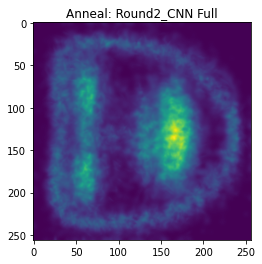

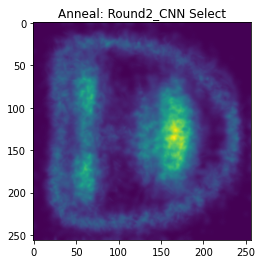

     RF training, Batch 1, rf_iter [1/40], Cluster: [0], loss_CE: 54.1156
     RF training, Batch 1, rf_iter [10/40], Cluster: [0], loss_CE: 54.1150
     RF training, Batch 1, rf_iter [20/40], Cluster: [0], loss_CE: 54.1150
     RF training, Batch 1, rf_iter [30/40], Cluster: [0], loss_CE: 54.1150
     RF training, Batch 1, rf_iter [40/40], Cluster: [0], loss_CE: 54.1150
     RF training, Batch 1, rf_iter [1/40], Cluster: [1], loss_CE: 37.9930
     RF training, Batch 1, rf_iter [10/40], Cluster: [1], loss_CE: 37.9916
     RF training, Batch 1, rf_iter [20/40], Cluster: [1], loss_CE: 37.9916
     RF training, Batch 1, rf_iter [30/40], Cluster: [1], loss_CE: 37.9916
     RF training, Batch 1, rf_iter [40/40], Cluster: [1], loss_CE: 37.9916
     RF training, Batch 1, rf_iter [1/40], Cluster: [2], loss_CE: 146.0780
     RF training, Batch 1, rf_iter [10/40], Cluster: [2], loss_CE: 143.0541
     RF training, Batch 1, rf_iter [20/40], Cluster: [2], loss_CE: 142.9166
     RF training, Batch 1

RuntimeError: ignored

In [20]:
# update using log likelihood

time_initial = time.time()
for round in range(1,Total_train):
  time_start = time.time()
  print("############################################################################")
  if torch.cuda.is_available():
    print("Round [%d/%d], Using GPU" %(round+1, Total_train))
  else:
    print("Round [%d/%d]" %(round+1, Total_train))

  
  ##################################################################################################################################################################
  ##################################################################################################################################################################
  ###
  ### Train Hourglass using gradient decent
  ### eyes: [36:48]
  ###
  ##################################################################################################################################################################
  ##################################################################################################################################################################
 
  if round == 0:
    leaf_q = {}
    for cluster_ind in range(Num_Clusters):
      leaf_q[cluster_ind] = (torch.ones(num_leaf_nodes[cluster_ind], cluster_len[cluster_ind], 256, 256)/(256*256)).to(device)
    cnn_Iters = 1
  else:
    cnn_Iters = nIters

  for iter in range(cnn_Iters):
    loss_epoch = 0
    for i, (x,_,y) in enumerate(ccommon_dataloder):
      x = x.cuda(non_blocking=True)
      x.requires_grad = True
      y = y.cuda(non_blocking=True)
      B = x.shape[0]
      outputs = torch.zeros(B,total_num_leaf_nodes).to(device)

      hg_out = Tune_HGNet.forward(x)
      outputs[:,torch.sum(num_leaf_nodes[0:0]):torch.sum(num_leaf_nodes[0:1])] = Linear0_tune.forward(hg_out)
      outputs[:,torch.sum(num_leaf_nodes[0:1]):torch.sum(num_leaf_nodes[0:2])] = Linear1_tune.forward(hg_out)
      outputs[:,torch.sum(num_leaf_nodes[0:2]):torch.sum(num_leaf_nodes[0:3])] = Linear2_tune.forward(hg_out)
      outputs[:,torch.sum(num_leaf_nodes[0:3]):torch.sum(num_leaf_nodes[0:4])] = Linear3_tune.forward(hg_out)
      outputs[:,torch.sum(num_leaf_nodes[0:4]):torch.sum(num_leaf_nodes[0:5])] = Linear4_tune.forward(hg_out)
      outputs[:,torch.sum(num_leaf_nodes[0:5]):torch.sum(num_leaf_nodes[0:6])] = Linear5_tune.forward(hg_out)
      outputs[:,torch.sum(num_leaf_nodes[0:6]):torch.sum(num_leaf_nodes[0:7])] = Linear6_tune.forward(hg_out)
      outputs[:,torch.sum(num_leaf_nodes[0:7]):torch.sum(num_leaf_nodes[0:8])] = Linear7_tune.forward(hg_out)
      outputs[:,torch.sum(num_leaf_nodes[0:8]):torch.sum(num_leaf_nodes[0:9])] = Linear8_tune.forward(hg_out)
      outputs[:,torch.sum(num_leaf_nodes[0:9]):torch.sum(num_leaf_nodes[0:10])] = Linear9_tune.forward(hg_out)


      outputs = outputs*(round*0.2+1)
      cnn_prob = phi(outputs)

      cnn_heatmaps = get_heatmap_full(cnn_prob, leaf_q)
      label_heatmaps = y.reshape(B*68,-1)
      label_heatmaps = label_heatmaps/torch.sum(label_heatmaps,axis=1,keepdims=True)
      loss = -torch.sum(label_heatmaps*torch.log(cnn_heatmaps+1e-8))/B

      loss_epoch += loss.item()
      if i == 109:
        loss_epoch = loss_epoch/110
        print('     CNN training, Iter [%d/%d], loss_CE: %.6f' %(iter+1, cnn_Iters, loss_epoch))
      
      optimizer.zero_grad()
      optimizer0.zero_grad()
      optimizer1.zero_grad()
      optimizer2.zero_grad()
      optimizer3.zero_grad()
      optimizer4.zero_grad()
      optimizer5.zero_grad()
      optimizer6.zero_grad()
      optimizer7.zero_grad()
      optimizer8.zero_grad()
      optimizer9.zero_grad()
      loss.backward()
      optimizer.step()
      optimizer0.step()
      optimizer1.step()
      optimizer2.step()
      optimizer3.step()
      optimizer4.step()
      optimizer5.step()
      optimizer6.step()
      optimizer7.step()
      optimizer8.step()
      optimizer9.step()

    if (iter+1)%5 == 0:
      cnn_intermediate_time = time.time()
      torch.save(Tune_HGNet.state_dict(),  os.path.join('Train_on_Common/Tune_HGNet_Round'+str(round+1)+'_Intermediate.pt'))
      torch.save(Linear0_tune.state_dict(), os.path.join('Train_on_Common/Linear0_Round'+str(round+1)+'_Intermediate.pt'))
      torch.save(Linear1_tune.state_dict(), os.path.join('Train_on_Common/Linear1_Round'+str(round+1)+'_Intermediate.pt'))
      torch.save(Linear2_tune.state_dict(), os.path.join('Train_on_Common/Linear2_Round'+str(round+1)+'_Intermediate.pt'))
      torch.save(Linear3_tune.state_dict(), os.path.join('Train_on_Common/Linear3_Round'+str(round+1)+'_Intermediate.pt'))
      torch.save(Linear4_tune.state_dict(), os.path.join('Train_on_Common/Linear4_Round'+str(round+1)+'_Intermediate.pt'))
      torch.save(Linear5_tune.state_dict(), os.path.join('Train_on_Common/Linear5_Round'+str(round+1)+'_Intermediate.pt'))
      torch.save(Linear6_tune.state_dict(), os.path.join('Train_on_Common/Linear6_Round'+str(round+1)+'_Intermediate.pt'))
      torch.save(Linear7_tune.state_dict(), os.path.join('Train_on_Common/Linear7_Round'+str(round+1)+'_Intermediate.pt'))
      torch.save(Linear8_tune.state_dict(), os.path.join('Train_on_Common/Linear8_Round'+str(round+1)+'_Intermediate.pt'))
      torch.save(Linear9_tune.state_dict(), os.path.join('Train_on_Common/Linear9_Round'+str(round+1)+'_Intermediate.pt'))
      print('     -----> CNN intermediate model saved, CNN training time till now: %.2f hrs' %((cnn_intermediate_time-time_start)/3600))

  # calculate time for CNN training
  time_cnn = time.time()
  print("     -----> CNN training time: ## %.2f hrs ## " %((time_cnn-time_start)/3600))

  # save model
  torch.save(Tune_HGNet.state_dict(),  os.path.join("Train_on_Common/Tune_HGNet_Round"+str(round+1)+'.pt'))
  torch.save(Linear0_tune.state_dict(), os.path.join("Train_on_Common/Linear0_Round"+str(round+1)+'.pt'))
  torch.save(Linear1_tune.state_dict(), os.path.join("Train_on_Common/Linear1_Round"+str(round+1)+'.pt'))
  torch.save(Linear2_tune.state_dict(), os.path.join("Train_on_Common/Linear2_Round"+str(round+1)+'.pt'))
  torch.save(Linear3_tune.state_dict(), os.path.join("Train_on_Common/Linear3_Round"+str(round+1)+'.pt'))
  torch.save(Linear4_tune.state_dict(), os.path.join("Train_on_Common/Linear4_Round"+str(round+1)+'.pt'))
  torch.save(Linear5_tune.state_dict(), os.path.join("Train_on_Common/Linear5_Round"+str(round+1)+'.pt'))
  torch.save(Linear6_tune.state_dict(), os.path.join("Train_on_Common/Linear6_Round"+str(round+1)+'.pt'))
  torch.save(Linear7_tune.state_dict(), os.path.join("Train_on_Common/Linear7_Round"+str(round+1)+'.pt'))
  torch.save(Linear8_tune.state_dict(), os.path.join("Train_on_Common/Linear8_Round"+str(round+1)+'.pt'))
  torch.save(Linear9_tune.state_dict(), os.path.join("Train_on_Common/Linear9_Round"+str(round+1)+'.pt'))
  print('     -----> CNN Round-Final Model Saved')

  # plot the face after CNN training
  # Does not select
  cnn_heatmaps = get_heatmap_full(cnn_prob, leaf_q).reshape(B,68,-1)
  first_face = torch.sum(cnn_heatmaps[0,:,:],axis=0)
  first_face = first_face/torch.sum(first_face)
  plt.imshow(first_face.reshape(256,256).detach().cpu())
  plt.title("Anneal: Round"+str(round+1)+"_CNN Full")
  plt.savefig(os.path.join("Train_on_Common/fig/Round"+str(round+1)+"_CNN_Full.png"))
  plt.show()

  # Selcet
  cnn_prob_test = phi(outputs, mode='test')
  cnn_heatmaps = get_heatmap_full(cnn_prob_test, leaf_q).reshape(B,68,-1)
  first_face = torch.sum(cnn_heatmaps[0,:,:],axis=0)
  first_face = first_face/torch.sum(first_face)
  plt.imshow(first_face.reshape(256,256).detach().cpu())
  plt.title("Anneal: Round"+str(round+1)+"_CNN Select")
  plt.savefig(os.path.join("Train_on_Common/fig/Round"+str(round+1)+"_CNN_Select.png"))
  plt.show()

  ##################################################################################################################################################################
  ##################################################################################################################################################################
  ###
  ### Train Regression Trees using variational bounding
  ###
  ##################################################################################################################################################################
  ##################################################################################################################################################################
  with torch.no_grad():
    loss0, loss_select = 0, 0
    new_leaf_q = {}
    for key_q in leaf_q.keys():
      new_leaf_q[key_q] = torch.zeros(leaf_q[key_q].shape).to(device)


    for i, (x,coord,y) in enumerate(rcommon_dataloder):
      # next_leaf_q = leaf_q.clone()
      x = x.cuda(non_blocking=True)
      y = y.cuda(non_blocking=True)
      coord = coord.cuda(non_blocking=True)
      B = x.shape[0]
      y_expand = y.reshape(B,68,-1) #(200,68,256*256)
      outputs = torch.zeros(B,total_num_leaf_nodes).to(device)

      hg_out = Tune_HGNet.forward(x)
      outputs[:,torch.sum(num_leaf_nodes[0:0]):torch.sum(num_leaf_nodes[0:1])] = Linear0_tune.forward(hg_out)
      outputs[:,torch.sum(num_leaf_nodes[0:1]):torch.sum(num_leaf_nodes[0:2])] = Linear1_tune.forward(hg_out)
      outputs[:,torch.sum(num_leaf_nodes[0:2]):torch.sum(num_leaf_nodes[0:3])] = Linear2_tune.forward(hg_out)
      outputs[:,torch.sum(num_leaf_nodes[0:3]):torch.sum(num_leaf_nodes[0:4])] = Linear3_tune.forward(hg_out)
      outputs[:,torch.sum(num_leaf_nodes[0:4]):torch.sum(num_leaf_nodes[0:5])] = Linear4_tune.forward(hg_out)
      outputs[:,torch.sum(num_leaf_nodes[0:5]):torch.sum(num_leaf_nodes[0:6])] = Linear5_tune.forward(hg_out)
      outputs[:,torch.sum(num_leaf_nodes[0:6]):torch.sum(num_leaf_nodes[0:7])] = Linear6_tune.forward(hg_out)
      outputs[:,torch.sum(num_leaf_nodes[0:7]):torch.sum(num_leaf_nodes[0:8])] = Linear7_tune.forward(hg_out)
      outputs[:,torch.sum(num_leaf_nodes[0:8]):torch.sum(num_leaf_nodes[0:9])] = Linear8_tune.forward(hg_out)
      outputs[:,torch.sum(num_leaf_nodes[0:9]):torch.sum(num_leaf_nodes[0:10])] = Linear9_tune.forward(hg_out)


      outputs = outputs*(round*0.2+1)
      cnn_prob = phi(outputs)
      cnn_prob_select = phi(outputs, mode='test')

      for cluster_ind in range(Num_Clusters):
        nleaf_start = torch.sum(num_leaf_nodes[0:cluster_ind]).item()
        nleaf_end = torch.sum(num_leaf_nodes[0:cluster_ind+1]).item()
        pts_start = torch.sum(cluster_len[0:cluster_ind]).item()
        pts_end = torch.sum(cluster_len[0:cluster_ind+1]).item()

        this_prob = cnn_prob[:,nleaf_start:nleaf_end]
        this_prob_select = cnn_prob_select[:,nleaf_start:nleaf_end]

        this_y_expand = y_expand[:,pts_start:pts_end,:]
        this_coord = coord[:,pts_start:pts_end,:]

        this_leaf_q = leaf_q[cluster_ind]
        q1,q2 = this_leaf_q.shape[0:2]
        this_leaf_q = this_leaf_q.reshape(q1,q2,-1)
        next_leaf_q = this_leaf_q.clone()

        for rf_iter in range(rf_Iters):
          for points_id in range(int(pts_end-pts_start)):
            next_leaf_q[:,points_id,:] = update_iter(next_leaf_q[:,points_id,:], this_prob, this_y_expand[:,points_id,:])
          if ((i+1)%5 == 0 or i == 0) and ((rf_iter+1)%10 == 0 or rf_iter == 0):
            rf_loss_CE = loss_alogb(B, next_leaf_q, this_prob, this_y_expand)
            print("     RF training, Batch %d, rf_iter [%d/%d], Cluster: [%d], loss_CE: %.4f" %(i+1, rf_iter+1, rf_Iters, cluster_ind, rf_loss_CE))
        
        new_leaf_q[cluster_ind] += next_leaf_q.reshape(next_leaf_q.shape[0],-1,256,256)

        # Calculate loss
        pred_coord0 = find_coord(torch.matmul(this_prob,next_leaf_q.reshape(next_leaf_q.shape[0],-1)), next_leaf_q.shape[1]) #(N,68*2)
        loss0 += torch.sum(torch.abs(pred_coord0-this_coord.reshape(B,-1)))/B
        pred_coord_select = find_coord(torch.matmul(this_prob_select,next_leaf_q.reshape(next_leaf_q.shape[0],-1)), next_leaf_q.shape[1])
        loss_select += torch.sum(torch.abs(pred_coord_select-this_coord.reshape(B,-1)))/B
      
      if (i+1)%5 == 0:
        rf_intermediate_time = time.time()
        torch.save(new_leaf_q, os.path.join("Train_on_Common/leaf_q_Round"+str(round+1)+'_Intermediate.pt'))
        print('     -----> Leaf_q intermediate results saved, RF training time till now: %.2f hrs' %((rf_intermediate_time-time_cnn)/3600))

    # update leaf node
    for key_q in leaf_q.keys():
      sum_leaf = new_leaf_q[key_q]
      sum_leaf = sum_leaf.reshape(sum_leaf.shape[0],sum_leaf.shape[1],-1)
      leaf_q[key_q] = (sum_leaf/torch.sum(sum_leaf, axis=2, keepdims=True)).reshape(sum_leaf.shape[0],sum_leaf.shape[1],256,256)
    


  # plot the face after rf training
  # Does not select
  rf_heatmaps = get_heatmap_full(cnn_prob, leaf_q).reshape(B,68,-1)
  first_face = torch.sum(rf_heatmaps[0,:,:],axis=0)
  first_face = first_face/torch.sum(first_face)
  plt.imshow(first_face.reshape(256,256).detach().cpu())
  plt.title("Anneal: Round"+str(round+1)+"_RF Full")
  plt.savefig(os.path.join("Train_on_Common/fig/Round"+str(round+1)+"_RF_Full.png"))
  plt.show()

  # Select
  cnn_prob_test = phi(outputs, mode='test')
  rf_heatmaps = get_heatmap_full(cnn_prob_test, leaf_q).reshape(B,68,-1)
  first_face = torch.sum(rf_heatmaps[0,:,:],axis=0)
  first_face = first_face/torch.sum(first_face)
  plt.imshow(first_face.reshape(256,256).detach().cpu())
  plt.title("Anneal: Round"+str(round+1)+"_RF Select")
  plt.savefig(os.path.join("Train_on_Common/fig/Round"+str(round+1)+"_RF_Select.png"))
  plt.show()

  # Plot Coordinate prediction for clusters
  cluster_heatmaps = get_heatmap_full(cnn_prob, leaf_q).reshape(B,-1)
  cluster_coord = find_coord(cluster_heatmaps, P=68)
  lcoord = coord.reshape(B,-1)
  lx = lcoord[0,::2]
  ly = lcoord[0,1::2]
  l_eyec_x = (torch.sum(lx[36:42])/6)
  l_eyec_y = (torch.sum(ly[36:42])/6)
  r_eyec_x = (torch.sum(lx[42:48])/6)
  r_eyec_y = (torch.sum(lx[42:48])/6)
  pupil = torch.sqrt((l_eyec_x-r_eyec_x)**2 + (l_eyec_y-r_eyec_y)**2).item()
  for c in range(Num_Clusters):
    mask_cluster = (group_landmarks==c)
    x = (cluster_coord[0,::2][mask_cluster]).detach().cpu()
    y = (cluster_coord[0,1::2][mask_cluster]).detach().cpu()
    lx = (lcoord[0,::2][mask_cluster]).detach().cpu()
    ly = (lcoord[0,1::2][mask_cluster]).detach().cpu()
    sx = (cluster_coord[0,::2][mask_cluster] - lcoord[0,::2][mask_cluster])**2
    sy = (cluster_coord[0,1::2][mask_cluster] - lcoord[0,1::2][mask_cluster])**2
    loss_cluster = torch.sum(torch.sqrt(sx+sy))/torch.sum(mask_cluster)/pupil*100
    loss_cluster = (loss_cluster.cpu()*100//1).item()/100
    plt.scatter(x,256-y, label='prediction')
    plt.scatter(lx,256-ly, label='label')
    plt.legend()
    plt.xlim(0,256)
    plt.ylim(0,256)
    plt.title('Round'+str(round+1)+' Cluster'+str(c)+' NME: '+str(loss_cluster))
    plt.savefig(os.path.join("Train_on_Common/fig/Round"+str(round+1)+"_Cluster"+str(c)+"_Coord.png"))
    plt.show()

  x = cluster_coord[0,::2].detach().cpu()
  y = cluster_coord[0,1::2].detach().cpu()
  lx = lcoord[0,::2].detach().cpu()
  ly = lcoord[0,1::2].detach().cpu()
  loss_cluster = torch.sum(torch.sqrt((x-lx)**2+(y-ly)**2))/68/pupil*100
  loss_cluster = (loss_cluster.cpu()*100//1).item()/100
  plt.scatter(x,256-y, label='prediction')
  plt.scatter(lx,256-ly, label='label')
  plt.legend()
  plt.xlim(0,256)
  plt.ylim(0,256)
  plt.title('Round'+str(round+1)+' Full Face, NME: '+str(loss_cluster))
  plt.savefig(os.path.join("Train_on_Common/fig/Round"+str(round+1)+"_FullFace_Coord.png"))
  plt.show()

  print("     RF training, coordinate loss: %.2f, after selcetion: %.2f" %(loss0/110, loss_select/110))

  # save parameters for this round
  torch.save(leaf_q, os.path.join("Train_on_Common/leaf_q_Round"+str(round+1)+'.pt'))
  print('     -----> Leaf_q Round-Final Result Saved')
  
  # calculate time for rf training
  time_rf = time.time()
  print("     -----> RF training time: ## %.2f hrs ## " %((time_rf-time_cnn)/3600))
  print("     -----> Training time for this round: ## %.2f mins ## " %((time_rf-time_start)/60))

# Finish Training
torch.save(Tune_HGNet.state_dict(),  os.path.join("Train_on_Common/Tune_HGNet_final.pt"))
torch.save(Linear0_tune.state_dict(), os.path.join("Train_on_Common/Linear0_final.pt"))
torch.save(Linear1_tune.state_dict(), os.path.join("Train_on_Common/Linear1_final.pt"))
torch.save(Linear2_tune.state_dict(), os.path.join("Train_on_Common/Linear2_final.pt"))
torch.save(Linear3_tune.state_dict(), os.path.join("Train_on_Common/Linear3_final.pt"))
torch.save(Linear4_tune.state_dict(), os.path.join("Train_on_Common/Linear4_final.pt"))
torch.save(Linear5_tune.state_dict(), os.path.join("Train_on_Common/Linear5_final.pt"))
torch.save(Linear6_tune.state_dict(), os.path.join("Train_on_Common/Linear6_final.pt"))
torch.save(Linear7_tune.state_dict(), os.path.join("Train_on_Common/Linear7_final.pt"))
torch.save(Linear8_tune.state_dict(), os.path.join("Train_on_Common/Linear8_final.pt"))
torch.save(Linear9_tune.state_dict(), os.path.join("Train_on_Common/Linear9_final.pt"))
torch.save(leaf_q, os.path.join("Train_on_Common/leaf_q_final.pt"))

# calculate total training time
time_end = time.time()
print("-----> Total training time: ## %.2f hrs ## " %((time_end-time_initial)/3600))

## 4.5 Visulize train results

In [ ]:
for ith in range(10):
  px = pred_coord0[ith,::2].detach().cpu()
  py = pred_coord0[ith,1::2].detach().cpu()

  lx = coord[ith,36:48,0].detach().cpu()
  ly = coord[ith,36:48,1].detach().cpu()

  plt.scatter(lx,256-ly,label='Label')
  plt.scatter(px,256-py,label='Prediction')

  plt.xlim(0,256)
  plt.ylim(0,256)
  plt.title(str(ith)+"th Train Sample - Full")
  plt.legend(loc='lower left')
  plt.show()

In [ ]:
for ith in range(10):
  px = pred_coord_select[ith,::2].detach().cpu()
  py = pred_coord-select[ith,1::2].detach().cpu()

  lx = coord[ith,36:48,0].detach().cpu()
  ly = coord[ith,36:48,1].detach().cpu()

  plt.scatter(lx,256-ly,label='Label')
  plt.scatter(px,256-py,label='Prediction')

  plt.xlim(0,256)
  plt.ylim(0,256)
  plt.title(str(ith)+"th Train Sample - Select")
  plt.legend(loc='lower left')
  plt.show()